In [1]:
import tensorflow as tf
import numpy as np 
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
image_dir = 'flowers/'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

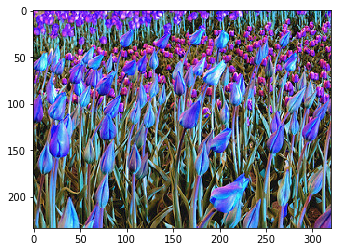

In [3]:
for category in categories:
    path = os.path.join(image_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        break

In [4]:
categories.index('rose')

2

In [5]:
def create_dataset(img_size = 100):
    
    training_data = []
    
    
    for category in categories:
        path = os.path.join(image_dir, category)
        img_class = categories.index(category)
    
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (img_size, img_size))

                training_data.append([img_array, img_class])
            except Exception as e:
                print(e)
                
    return np.array(training_data)
        

In [6]:
training_data = create_dataset()

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [7]:
np.random.shuffle(training_data)

In [8]:
def plot_image(training_data, label):
    plt_imgs = 9
    
    fig, axes = plt.subplots(3, 3, figsize = (9,9))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(training_data[i])
        
        xlabel = categories[np.argmax(label[i])]
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [9]:
X = training_data[:,0]
y = training_data[:,1]

In [10]:
def one_hot(num_class, class_num):
    return np.eye(num_class)[class_num]

In [11]:
test_y = []
for i in range(len(y)):
    test_y.append(y[i])


In [12]:
test_x = []
for i in range(len(X)):
    test_x.append(X[i])

In [13]:
y = np.array(test_y)
y = one_hot(np.max(y)+1, y)

In [14]:
X = np.array(test_x)/255

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

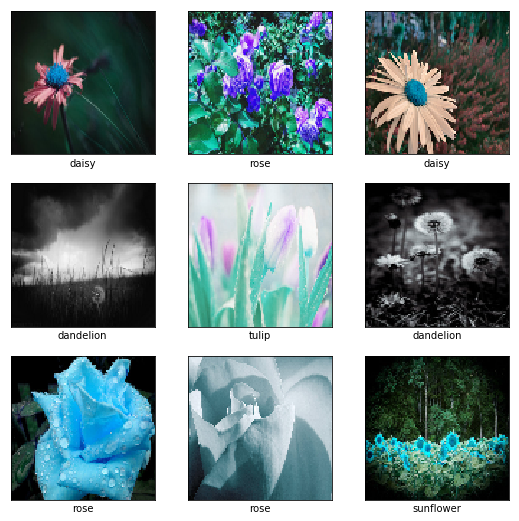

In [17]:
plot_image(X_train, y_train)

In [28]:
def next_batch(x, y, batch_size = 64):
    index = np.random.choice(len(x), size = batch_size)
    batch_x = x[index]
    batch_y = y[index]
    return batch_x, batch_y

In [43]:
# tensorflow

# placeholder
input_x = tf.placeholder(tf.float32, shape = [None, 100, 100, 3], name = 'input_image')
y_true = tf.placeholder(tf.float32, shape = [None, 5], name = 'y_true')

# weights, 第一层
weights_conv_1 = tf.Variable(tf.truncated_normal(shape = [8, 8, 3, 32], stddev = 0.1))
bias_1 = tf.Variable(tf.truncated_normal(shape = [32], stddev = 0.1))

# 第一层卷积层
conv_layer_first = tf.nn.conv2d(input_x, filter = weights_conv_1, strides = [1, 2, 2, 1], padding = 'VALID')
conv_layer_first = tf.nn.relu(conv_layer_first) + bias_1
max_pool_1 = tf.nn.max_pool(conv_layer_first, ksize = [1,2,2,1], strides = [1, 2, 2, 1], padding = 'VALID')

In [44]:
max_pool_1.shape

TensorShape([Dimension(None), Dimension(23), Dimension(23), Dimension(32)])

In [45]:
# weights, 第二层
weights_conv_2 = tf.Variable(tf.truncated_normal(shape = [8, 8, 32, 64], stddev = 0.1))
bias_2 = tf.Variable(tf.truncated_normal(shape = [64], stddev = 0.1))

# 第二层卷积层
conv_layer_second = tf.nn.conv2d(max_pool_1, weights_conv_2, strides = [1, 2, 2, 1], padding = 'VALID')
conv_layer_second = tf.nn.relu(conv_layer_second) + bias_2
max_pool_2 = tf.nn.max_pool(conv_layer_second, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

In [46]:
max_pool_2.shape

TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(64)])

In [47]:
# weights, 全连接层1
weights_flatten_1 = tf.Variable(tf.truncated_normal(shape = [4*4*64, 32], stddev = 0.1))
bias_flatten_1 = tf.Variable(tf.truncated_normal(shape = [32], stddev = 0.1))

# 全连接层1
flatten_x = tf.reshape(max_pool_2, (-1, 4*4*64))
flatten_1 = tf.matmul(flatten_x, weights_flatten_1)
flatten_1 = tf.nn.relu(flatten_1) + bias_flatten_1

# weights, 全连接层2
weights_flatten_2 = tf.Variable(tf.truncated_normal(shape = [32, 5], stddev = 0.1))
bias_flatten_2 = tf.Variable(tf.truncated_normal(shape = [5], stddev = 0.1))

# output
flatten_2 = tf.matmul(flatten_1, weights_flatten_2) + bias_flatten_2
y_pred = tf.nn.softmax(flatten_2)

In [48]:
y_pred.shape

TensorShape([Dimension(None), Dimension(5)])

In [50]:
# loss function

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits = y_pred))
train = tf.train.AdamOptimizer(learning_rate = 1e-5).minimize(loss)

In [52]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(5000):
        batch_x, batch_y = next_batch(X_train, y_train)
        sess.run(train, feed_dict = {input_x: batch_x, y_true: batch_y})
        
        if i % 100 == 0:
            test_x, test_y = next_batch(X_test, y_test)
            
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            print('Current step: ', i)
            print(sess.run(acc, feed_dict = {input_x: test_x, y_true: test_y}))

Current step:  0
0.25
Current step:  100
0.234375
Current step:  200
0.28125
Current step:  300
0.34375
Current step:  400
0.296875
Current step:  500
0.375
Current step:  600
0.3125
Current step:  700
0.3125
Current step:  800
0.546875
Current step:  900
0.421875
Current step:  1000
0.5
Current step:  1100
0.390625
Current step:  1200
0.5625
Current step:  1300
0.421875
Current step:  1400
0.546875
Current step:  1500
0.546875
Current step:  1600
0.484375
Current step:  1700
0.328125
Current step:  1800
0.5
Current step:  1900
0.46875
Current step:  2000
0.46875
Current step:  2100
0.65625
Current step:  2200
0.6875
Current step:  2300
0.5
Current step:  2400
0.578125
Current step:  2500
0.5625
Current step:  2600
0.546875
Current step:  2700
0.625
Current step:  2800
0.59375
Current step:  2900
0.484375
Current step:  3000
0.53125
Current step:  3100
0.625
Current step:  3200
0.59375
Current step:  3300
0.484375
Current step:  3400
0.421875
Current step:  3500
0.53125
Current step:  